# Résumé du TP

**Fonction softmax** : dans un problème de classification multiclasse, permet de transformer un score de prédiction pour chaque classe en une valeur de probabilité, normalisée par rapport à tous les scores

**Régression logistique** : prédiction des probabilités de classes avec une taille d'entrée fixée et 2 vecteurs de paramètres

**Descente de gradient** avec **Pytorch** pour optimisation des paramètres de la régression

**Maximum entropy Markov Model** : modèle séquentiel uniquement forward, ici appliqué au POS tagging et combiné avec des régressions logistiques

Objets manipulés : 
- image de chiffres écrits à la main convertis en vecteurs
- mots convertis en vecteurs de dim 100 (word embedding) avec l'algorithme Glove

### Imports initiaux

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import optim
import random
from sklearn.preprocessing import OneHotEncoder

# Exercice 1 : La fonction softmax

In [2]:
def softmax(x):
    """
    Renvoie la valeur de softmax(x) calculée de manière optimisée
    
    Args : x est un tenseur
    """
    a = torch.exp(x - torch.max(x))
    b = torch.sum(a)
    return a/b

In [3]:
# Vérification sur l'exemple
x = torch.tensor([5., 1., 2., -1.])
print('x :', x,'\nsoftmax(x) :', softmax(x))

x : tensor([ 5.,  1.,  2., -1.]) 
softmax(x) : tensor([0.9341, 0.0171, 0.0465, 0.0023])


In [4]:
# Comparaison des vitesses d'exécution
%timeit softmax(x)
%timeit torch.nn.Softmax()(x)

30.3 µs ± 3.98 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<magic-timeit>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


41.9 µs ± 4.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Exercice 2

##### Preprocessing

In [5]:
dataset = torchvision.datasets.MNIST("./", download = True)
train_set_y, train_set_x = dataset.data[:50000], dataset.targets[:50000]
test_set_y, test_set_x = dataset.data[50000:], dataset.targets[50000:]

In [6]:
train_set_y = (train_set_y.view(50000, -1) + 0.0)
mean_train, std_train = torch.mean(train_set_y), torch.std(train_set_y)
train_set_y = (train_set_y - mean_train)/std_train
train_set = []
for i in range(50000):
    train_set.append([train_set_x[i], train_set_y[i]])
    
test_set_y = (test_set_y.view(10000, -1) + 0.0)
mean_test, std_test = torch.mean(test_set_y), torch.std(test_set_y)
test_set_y = (test_set_y - mean_test)/std_test
test_set = []
for i in range(10000):
    test_set.append([test_set_x[i], test_set_y[i]])

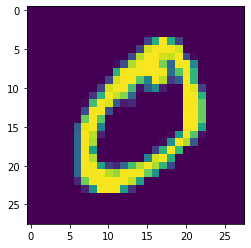

tensor(0)


In [7]:
# Visualisation sur un exemple
exemple = 1
plt.imshow(train_set[exemple][1].view(28, 28))
plt.show()
print(train_set[exemple][0])

### Régression logistique

In [8]:
# Initialisation des paramètres de la régression logistique : W et b

path = r"C:\Users\Pierrick\OneDrive\Bureau\K\2_MS_TelecomParis\Cours\IA702 - Modèles probabilistes et apprentissage automatique\Cours_4\TP4\TP4 functions-20211027"
W_lr = torch.load(path + "\TP4_functions\W_lr.pt").requires_grad_(True)
b_lr = torch.load(path + "\TP4_functions/b_lr.pt").requires_grad_(True)

In [9]:
def g(y, W, b):
    """
    Renvoie la prédiction et sa probabilité pour la classe x, en ayant observé l'observation y sous les paramètres W et b
    
    Returns : float
    
    Args:
        - y un tenseur, les features extraites de l'écriture manuelle pour l'observation y
        - W (tenseur): le vecteur des poids (=coefficients) à appliquer à chaque feature de y // Les poids dépendent de la classe -> extraire W_x de W 
        - b : un paramètre ne dépendant que la classe de x -> extraire b_x
  """
    p_x = softmax(y@(W_lr.T) + b_lr)
    pred = torch.argmax(p_x)
    return p_x, pred, float(p_x[pred])

In [10]:
def L(g, D, W, b):
    N = len(D)
    s = 0
    for x, y in D:
        truePred_proba = g(y, W, b)[0][x]
        s += torch.log(truePred_proba)
    return - 1 / N * s

In [11]:
L(g, train_set[:100], W_lr, b_lr)

tensor(2.4652, grad_fn=<MulBackward0>)

In [3]:
def minibatch(D, n=256):
    return random.sample(D, n)

0
Loss: tensor(2.4362)
50
Loss: tensor(2.1019)
100
Loss: tensor(1.7814)
150
Loss: tensor(1.5160)
200
Loss: tensor(1.4399)
250
Loss: tensor(1.2482)
300
Loss: tensor(1.1603)
350
Loss: tensor(1.0740)
400
Loss: tensor(0.9290)
450
Loss: tensor(0.8863)
500
Loss: tensor(0.8276)
550
Loss: tensor(0.8324)
600
Loss: tensor(0.7770)
650
Loss: tensor(0.7346)
700
Loss: tensor(0.7367)
750
Loss: tensor(0.7309)
800
Loss: tensor(0.6803)
850
Loss: tensor(0.6422)
900
Loss: tensor(0.6208)
950
Loss: tensor(0.5827)


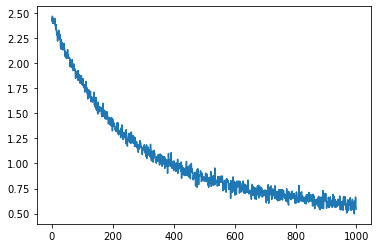

theta tensor([[ 0.0382, -0.0210, -0.0118,  ...,  0.0292,  0.0393, -0.0289],
        [ 0.0077, -0.0342, -0.0224,  ...,  0.0066,  0.0153,  0.0121],
        [ 0.0172,  0.0266,  0.0103,  ...,  0.0257,  0.0182,  0.0210],
        ...,
        [-0.0214,  0.0120,  0.0293,  ..., -0.0325,  0.0174,  0.0050],
        [ 0.0325,  0.0002,  0.0016,  ...,  0.0107, -0.0122, -0.0236],
        [-0.0050,  0.0358,  0.0016,  ...,  0.0129,  0.0373, -0.0333]],
       requires_grad=True) tensor([ 0.0078, -0.0141,  0.0171, -0.0376,  0.0297, -0.0038, -0.0216,  0.0035,
        -0.0246,  0.0075], requires_grad=True) 



In [13]:
alpha = 5e-5

K = 1000

list_L = torch.zeros(K)
optimizer = optim.Adam([W_lr, b_lr], lr=alpha)


for k in range(K):
    optimizer.zero_grad()
    loss = L(g, minibatch(train_set), W_lr, b_lr)
    loss.backward()
    optimizer.step()
    list_L[k] = loss.item()
    if k % 50 == 0:
        print(k)
        print("Loss:", list_L[k])
#         print("theta", W_lr, b_lr, "\n")
plt.plot(list_L)
plt.show()
print("theta", W_lr, b_lr, "\n")

In [14]:
l_pred = []
for y in test_set_y:
    l_pred.append(g(y, W_lr, b_lr)[1])

In [15]:
print('Score de classification sur le test_set : ', round(float((torch.tensor(l_pred) == test_set_x).sum()/len(test_set_x))*100,2) , '%')

Score de classification sur le test_set :  87.94 %


# Exercice 3 : Maximum Entropy Markov Model pour le POS tagging

##### Import

In [4]:
from TP4_functions.load_conll2000 import load_conll2000_glove
path = "TP4_functions/"
Omega_X, train_set, test_set = load_conll2000_glove(path)
y_train_set = [pair[1] for pair in train_set]

In [5]:
W_lr1 = torch.load("TP4_functions/W_lr1.pt").requires_grad_(True)
b_lr1 = torch.load("TP4_functions/b_lr1.pt").requires_grad_(True)
W_lr2 = torch.load("TP4_functions/W_lr2.pt").requires_grad_(True)
b_lr2 = torch.load("TP4_functions/b_lr2.pt").requires_grad_(True)

#### Définition des fonctions auxiliaires

In [6]:
def encoding(x):
    """
    Transforme x ('NOUN', 'ADJ') en tenseur par one hot encoding
    """
    res = torch.zeros(len(Omega_X))
    res[Omega_X.index(x)] = 1
    return res

d_encoding = {}
for x in Omega_X:
    d_encoding[x] = encoding(x)
d_encoding

def faster_encoding(x):
    return d_encoding[x]


card_Omega_X = len(Omega_X)

l=[]
for lambda_x in Omega_X:
    l.append(encoding(lambda_x))

Omega_X_encoded = torch.stack(l)


d_tagToCode = d_encoding.copy()
for key in d_tagToCode.keys():
    d_tagToCode[key] = (d_tagToCode[key] == 1).nonzero().item()
    
def tagToCode(tag):
    return d_tagToCode[tag]

#### Fonctions de régression, de coût et MEMM

In [7]:
# Fonction de régression logistique
def g(y, W, b):
    return softmax(y@(W.T) + b)

In [8]:
# Fonction permettant de trouver récursivement le alpha t+1
def find_next_alpha(alpha, g, W_lr2, b_lr2, word):
    
    res = torch.zeros(card_Omega_X)
    for j in range(card_Omega_X):
        v = torch.cat((word, Omega_X_encoded[j]))
        res += alpha[j] * g(v, W_lr2, b_lr2)
    return res

In [9]:
# Fonction MEMM
def MEMM(sentence, W_lr1, b_lr1, W_lr2, b_lr2):
    
    # Initialisation avec L1
    l_alpha = []
    l_alpha.append(g(sentence[0], W_lr1, b_lr1))
    
    # Récursion
    for word in sentence[1:]:
        l_alpha.append(find_next_alpha(l_alpha[-1], g, W_lr2, b_lr2, word))
    return l_alpha

In [10]:
# Fonction calculant la loss cross entropy et le score sur le train_set pour
# essayer de vérifier qu'il n'y a pas d'overfitting

def LCE(MEMM, D, W_lr1, b_lr1, W_lr2, b_lr2):
    loss = 0
    score = 0
    N = 0 # le nombre total de mots
    for tags, sentence in D:
        n = len(sentence) # le nombre de mots dans sentence
        N = N + n
        result = list(map(tagToCode, tags))
        for alpha, truth in list(zip(MEMM(sentence, W_lr1, b_lr1, W_lr2, b_lr2), result)):
            pred = torch.argmax(alpha)
            loss += -torch.log(alpha[truth])
            if pred == truth:
                score += 1
    return loss / N, score / N


LCE(MEMM, minibatch(train_set, 32), W_lr1, b_lr1, W_lr2, b_lr2)

(tensor(2.7412, grad_fn=<DivBackward0>), 0.07547169811320754)

#### Affichage de la valeur de la loss sur les 10 premiers exemples du train_set

In [11]:
LCE(MEMM, train_set[:10], W_lr1, b_lr1, W_lr2, b_lr2)

(tensor(2.7459, grad_fn=<DivBackward0>), 0.08333333333333333)

#### Descente de gradient pour l'optimisation des paramètres du MEMM

0
Loss: tensor(2.7307)
Loss: tensor(2.7307, grad_fn=<DivBackward0>)
Score sur le train_set: 0.0815006468305304
Score sur le test_set: 0.09048694514215759
50
Loss: tensor(2.2780)
Loss: tensor(2.2780, grad_fn=<DivBackward0>)
Score sur le train_set: 0.35834411384217335
Score sur le test_set: 0.3317221436562045
100
Loss: tensor(2.0255)
Loss: tensor(2.0255, grad_fn=<DivBackward0>)
Score sur le train_set: 0.4675324675324675
Score sur le test_set: 0.46600671211769423
150
Loss: tensor(1.8205)
Loss: tensor(1.8205, grad_fn=<DivBackward0>)
Score sur le train_set: 0.543010752688172
Score sur le test_set: 0.5281465690102792
200
Loss: tensor(1.6122)
Loss: tensor(1.6122, grad_fn=<DivBackward0>)
Score sur le train_set: 0.6075581395348837
Score sur le test_set: 0.564324461236465
250
Loss: tensor(1.5368)
Loss: tensor(1.5368, grad_fn=<DivBackward0>)
Score sur le train_set: 0.595873786407767
Score sur le test_set: 0.598518268358064
300
Loss: tensor(1.4249)
Loss: tensor(1.4249, grad_fn=<DivBackward0>)
Scor

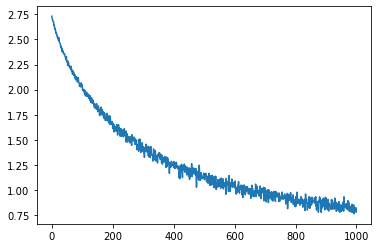

In [12]:
learning_rate = 5e-4

K = 1000

list_L = torch.zeros(K)
optimizer = optim.Adam([W_lr1, b_lr1, W_lr2, b_lr2], lr=learning_rate)


for k in range(K):
    optimizer.zero_grad()
    loss, score_train = LCE(MEMM, minibatch(train_set, 32), W_lr1, b_lr1, W_lr2, b_lr2)
    loss.backward()
    optimizer.step()
    list_L[k] = loss.item()
    if k % 50 == 0:
        print(k)
        print("Loss:", list_L[k])
        print("Loss:", loss)
        print("Score sur le train_set:", score_train)
        
        # Calcul du score sur le test_set
        score_test = 0 
        N = 0
        for tags, sentence in test_set:
            N += len(sentence)
            result = list(map(tagToCode, tags))
            for alpha, truth in list(zip(MEMM(sentence, W_lr1, b_lr1, W_lr2, b_lr2), result)):
                pred = torch.argmax(alpha)
                if pred == truth:
                    score_test += 1
        score_test = score_test/N
        print("Score sur le test_set:", score_test)

plt.plot(list_L)
plt.show()

# Conclusion

**Le score sur le test_set est de 77%.**
Il ne semble pas y avoir d'overfit car les score sont quasiment identiques sur le test_set et le train_set (peut-être pas utile de le vérifier car repose sur des régressions donc jamais d'overfit sauf en grande dimension ?)

A améliorer : optimiser la vitesse d'exécution du code en estimant systématiquement le temps consommé par chaque partie du code car la descente de gradient a été très longue (de l'ordre d'une heure)